In [32]:
%matplotlib inline

import networkx as nx
import unicodecsv as csv
import pandas as pd
import matplotlib.pyplot as plt
import operator
import numpy as np
import scipy.stats as st
import community

In [3]:
def graph_from_csv(path):
    graph = nx.Graph(name = "Heroic Social Network")
    with open(path, 'r') as data:
        reader = csv.reader(data)
        for row in reader:
            graph.add_edge(*row)
    return graph

In [4]:
df = pd.read_csv('data/hero-network.csv', names=['Vector_1', 'Vector_2'])
df.head()

,Vector_1,Vector_2
0,"LITTLE, ABNER",PRINCESS ZANDA
1,"LITTLE, ABNER",BLACK PANTHER/T'CHAL
2,BLACK PANTHER/T'CHAL,PRINCESS ZANDA
3,"LITTLE, ABNER",PRINCESS ZANDA
4,"LITTLE, ABNER",BLACK PANTHER/T'CHAL


In [5]:
def graph_from_gdf(path):
    graph = nx.Graph(name="Characters in Comics")
    with open(path, 'rU') as data:
        reader = csv.reader(data)
        for row in reader:
            if 'nodedef' in row[0]:
                handler = lambda row, G: G.add_node(row[0], TYPE=row[1])
            elif 'edgedef' in row[0]:
                handler = lambda row, G: G.add_edge(*row)
            else:
                handler(row, graph)
    return graph

In [30]:
print nx.info(graph)

Name: Heroic Social Network
Type: Graph
Number of nodes: 6426
Number of edges: 167219
Average degree:  52.0445


In [31]:
print nx.info(graph2)

Name: Characters in Comics
Type: Graph
Number of nodes: 19090
Number of edges: 96104
Average degree:  10.0685


In [46]:
def draw_ego_graph(graph, character, hops=1):
    """Expecting a graph_from_gdf."""
    
    # Get the ego graph and position
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(12,12))
    plt.axis('off')
    
    # Coloration and Configuration
    ego.node[character]["TYPE"] = "center"
    valmap = {
        "comic": 0.25, 
        "hero": 0.54, 
        "center": 0.87}
    types = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in 
              ego.nodes()]
    
    # Draw
    nx.draw_networkx_edges(ego, pos, alpha = 0.4)
    nx.draw_networkx_nodes(ego, pos,
                          node_size=80,
                          node_color=values,
                          cmap=plt.cm.hot,
                          with_labels=False)
    plt.show()
    

In [50]:
graph2.nodes(data=True)

[(u'QUESADA, JOE', {'TYPE': u'hero'}),
 (u'PM&andIF 90', {'TYPE': u'comic'}),
 (u'ZEITGEIST II/AXEL CL', {'TYPE': u'hero'}),
 (u'DREAMING CELESTIAL/T', {'TYPE': u'hero'}),
 (u'PM&andIF 97', {'TYPE': u'comic'}),
 (u'PIECEMEAL/GILBERT BE', {'TYPE': u'hero'}),
 (u'BP 2', {'TYPE': u'comic'}),
 (u'BP 3', {'TYPE': u'comic'}),
 (u'IM 213', {'TYPE': u'comic'}),
 (u'BP 1', {'TYPE': u'comic'}),
 (u'BP 6', {'TYPE': u'comic'}),
 (u'BP 7', {'TYPE': u'comic'}),
 (u'BP 4', {'TYPE': u'comic'}),
 (u'BP 5', {'TYPE': u'comic'}),
 (u'IM 219', {'TYPE': u'comic'}),
 (u'IM 218', {'TYPE': u'comic'}),
 (u'BP 8', {'TYPE': u'comic'}),
 (u'BP 9', {'TYPE': u'comic'}),
 (u'UX 229', {'TYPE': u'comic'}),
 (u'TTA2 12/2', {'TYPE': u'comic'}),
 (u'MOKF 17', {'TYPE': u'comic'}),
 (u'BENWAY, DR.', {'TYPE': u'hero'}),
 (u'FRIEDLANDER, SHARON', {'TYPE': u'hero'}),
 (u'MOKF 19', {'TYPE': u'comic'}),
 (u'MOKF 18', {'TYPE': u'comic'}),
 (u'SINGER, MERLE', {'TYPE': u'hero'}),
 (u'ROM 39', {'TYPE': u'comic'}),
 (u'LOGA II', {'TY

In [8]:
def transform_to_weighted_heros(graph, outpath="data/weighted_heros.csv"):
    # Create new graph to fill in
    heros = nx.Graph(name="Weighted Heroic Social Network")

    # Iterate through all the nodes and their properties
    for node, data in graph.nodes(data=True):
        # We don't care about comics, only heros
        if data['TYPE'] == 'comic': continue
        # Add the hero and their properties (this will also update data)
        heros.add_node(node, **data) # Add or update nodes

        # Find all the heros connected via the comic books
        for comic in graph[node]:
            for alter in graph[comic]:
                # Skip the same hero in the comic
                if alter == node: continue

                # Setup the default edge
                if alter not in heros[node]:
                    heros.add_edge(node, alter, weight=0.0, label="knows")

                # The weight of the hero is the fraction of connections / 2
                heros[node][alter]["weight"] += 1.0 / (graph.degree(comic) *2)
    return heros

In [7]:
def get_weighted_ego_graph(graph, character, hops=1):
    # Graph and Position
    ego = nx.ego_graph(graph, character, hops)
    pos = nx.spring_layout(ego)
    plt.figure(figsize=(12,12))
    plt.axis('off')

    # Coloration and Configuration
    ego.node[character]["TYPE"] = "center"
    valmap = { "hero": 0.0, "center": 1.0 }
    types  = nx.get_node_attributes(ego, "TYPE")
    values = [valmap.get(types[node], 0.25) for node in ego.nodes()]

    char_edges = ego.edges(data=True, nbunch=[character,])
    nonchar_edges = ego.edges(nbunch=[n for n in ego.nodes() if n != character])
    elarge=[(u,v) for (u,v,d) in char_edges if d['weight'] >=0.12]
    esmall=[(u,v) for (u,v,d) in char_edges if d['weight'] < 0.12]
    print set([d['weight'] for (u,v,d) in char_edges])

    # Draw
    nx.draw_networkx_nodes(ego, pos,
                           node_size=200,
                           node_color=values,
                           cmap=plt.cm.Paired, with_labels=False)

    nx.draw_networkx_edges(ego,pos,edgelist=elarge,
                        width=1.5, edge_color='b')
    nx.draw_networkx_edges(ego,pos,edgelist=esmall,
                        width=1,alpha=0.5,edge_color='b',style='dashed')
    nx.draw_networkx_edges(ego,pos,edgelist=nonchar_edges,
                        width=0.5,alpha=0.2,style='dashed')

    plt.show()
    #plt.savefig("figure/weighted_longbow_ego.png")

Name: Weighted Heroic Social Network
Type: Graph
Number of nodes: 6439
Number of edges: 171644
Average degree:  53.3139
set([0.05555555555555555, 0.16666666666666669, 0.16666666666666666, 0.1111111111111111])


/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:650: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != str('face'):
/Users/nathankiner/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


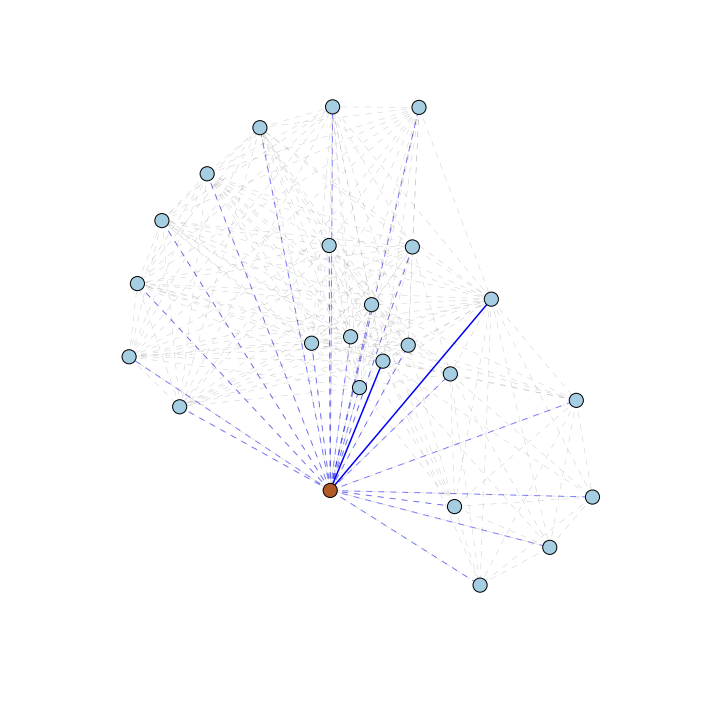

In [9]:
if __name__ == '__main__':
    graph = graph_from_csv('data/hero-network.csv')
    graph2 = graph_from_gdf('data/comic-hero-network.gdf')
    heros = transform_to_weighted_heros(graph2)
    print nx.info(heros)
    get_weighted_ego_graph(heros, "LONGBOW/AMELIA GREER")

In [66]:
for node, data in graph2.nodes(data=True):
    print node, data

QUESADA, JOE {'TYPE': u'hero'}
PM&andIF 90 {'TYPE': u'comic'}
ZEITGEIST II/AXEL CL {'TYPE': u'hero'}
DREAMING CELESTIAL/T {'TYPE': u'hero'}
PM&andIF 97 {'TYPE': u'comic'}
PIECEMEAL/GILBERT BE {'TYPE': u'hero'}
BP 2 {'TYPE': u'comic'}
BP 3 {'TYPE': u'comic'}
IM 213 {'TYPE': u'comic'}
BP 1 {'TYPE': u'comic'}
BP 6 {'TYPE': u'comic'}
BP 7 {'TYPE': u'comic'}
BP 4 {'TYPE': u'comic'}
BP 5 {'TYPE': u'comic'}
IM 219 {'TYPE': u'comic'}
IM 218 {'TYPE': u'comic'}
BP 8 {'TYPE': u'comic'}
BP 9 {'TYPE': u'comic'}
UX 229 {'TYPE': u'comic'}
TTA2 12/2 {'TYPE': u'comic'}
MOKF 17 {'TYPE': u'comic'}
BENWAY, DR. {'TYPE': u'hero'}
FRIEDLANDER, SHARON {'TYPE': u'hero'}
MOKF 19 {'TYPE': u'comic'}
MOKF 18 {'TYPE': u'comic'}
SINGER, MERLE {'TYPE': u'hero'}
ROM 39 {'TYPE': u'comic'}
LOGA II {'TYPE': u'hero'}
MODRED THE MYSTIC {'TYPE': u'hero'}
ROM 31 {'TYPE': u'comic'}
ROM 30 {'TYPE': u'comic'}
ROM 33 {'TYPE': u'comic'}
ROM 32 {'TYPE': u'comic'}
ROM 35 {'TYPE': u'comic'}
ROM 34 {'TYPE': u'comic'}
DR. FAUSTUS {'TY

In [69]:
graph2["E 18"]

{u'DAMIAN, MARGO': {},
 u'DREAMING CELESTIAL/T': {},
 u'DRUIG': {},
 u'GAMMENON [CELESTIAL]': {},
 u'HOLDEN, DR. SAMUEL': {},
 u'IKARIS/IKE HARRIS [E': {},
 u'MAKKARI/MIKE KHARY/I': {},
 u'SERSI/SYLVIA': {},
 u'SIGMAR': {},
 u'ZIRAN': {},
 u'ZURAS': {}}

In [72]:
degrees = sorted(graph.degree().items(), key=operator.itemgetter(1), reverse=True)
for node in degrees: print node

(u'CAPTAIN AMERICA', 1908)
(u'SPIDER-MAN/PETER PAR', 1737)
(u'IRON MAN/TONY STARK ', 1522)
(u'THING/BENJAMIN J. GR', 1416)
(u'MR. FANTASTIC/REED R', 1379)
(u'WOLVERINE/LOGAN ', 1371)
(u'HUMAN TORCH/JOHNNY S', 1361)
(u'SCARLET WITCH/WANDA ', 1325)
(u'THOR/DR. DONALD BLAK', 1289)
(u'BEAST/HENRY &HANK& P', 1267)
(u'VISION ', 1241)
(u'INVISIBLE WOMAN/SUE ', 1236)
(u'HAWK', 1175)
(u'WASP/JANET VAN DYNE ', 1091)
(u'ANT-MAN/DR. HENRY J.', 1082)
(u'CYCLOPS/SCOTT SUMMER', 1081)
(u'ANGEL/WARREN KENNETH', 1073)
(u'STORM/ORORO MUNROE S', 1072)
(u'SHE-HULK/JENNIFER WA', 1071)
(u'DR. STRANGE/STEPHEN ', 1067)
(u'HULK/DR. ROBERT BRUC', 1055)
(u'WONDER MAN/SIMON WIL', 1033)
(u'PROFESSOR X/CHARLES ', 1032)
(u'COLOSSUS II/PETER RA', 1025)
(u'MARVEL GIRL/JEAN GRE', 1005)
(u'HERCULES [GREEK GOD]', 991)
(u'JARVIS, EDWIN ', 986)
(u'SUB-MARINER/NAMOR MA', 979)
(u'DAREDEVIL/MATT MURDO', 967)
(u'ICEMAN/ROBERT BOBBY ', 945)
(u'FURY, COL. NICHOLAS ', 922)
(u'BLACK WIDOW/NATASHA ', 922)
(u'JAMESON, J. JONAH', 920)

In [10]:
centrality = nx.degree_centrality(graph)
centrality

{u'QUESADA, JOE': 0.006070038910505837,
 u'ZEITGEIST II/AXEL CL': 0.0015564202334630351,
 u'LOGA II': 0.0068482490272373546,
 u'PIECEMEAL/GILBERT BE': 0.006536964980544747,
 u'BENWAY, DR.': 0.0028015564202334632,
 u'FRIEDLANDER, SHARON': 0.019610894941634243,
 u'DREAMING CELESTIAL/T': 0.00575875486381323,
 u'MODRED THE MYSTIC': 0.01509727626459144,
 u'THOMAS, DR. STAN': 0.0017120622568093386,
 u'FIREWALL/THEARY/MIN ': 0.007315175097276265,
 u'DR. FAUSTUS': 0.0038910505836575876,
 u'RAYMOND, NORA JONES': 0.0018677042801556422,
 u'24-HOUR MAN/EMMANUEL': 0.0007782101167315176,
 u'MARROW/SARAH ': 0.03766536964980545,
 u'EPOCH': 0.023813229571984437,
 u'TIMBERIUS': 0.011828793774319068,
 u'KRO [DEVIANT]': 0.02256809338521401,
 u'OMNIBUS/LT. DALLAS': 0.0068482490272373546,
 u'GRIS-GRIS': 0.006692607003891051,
 u'WHIZZER III/JAMES SA': 0.02303501945525292,
 u'KORATH THE PURSUER': 0.009494163424124515,
 u'OMEGA RED/ARKADY ROS': 0.017120622568093387,
 u'WOLFE, HEDY': 0.0056031128404669265,
 u'S

In [11]:
nx.set_node_attributes(graph, 'centrality', centrality)

In [12]:
degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
for item in degrees[0:10]: print "%s: %0.3f" % item

CAPTAIN AMERICA: 0.297
SPIDER-MAN/PETER PAR: 0.270
IRON MAN/TONY STARK : 0.237
THING/BENJAMIN J. GR: 0.220
MR. FANTASTIC/REED R: 0.215
WOLVERINE/LOGAN : 0.213
HUMAN TORCH/JOHNNY S: 0.212
SCARLET WITCH/WANDA : 0.206
THOR/DR. DONALD BLAK: 0.201
BEAST/HENRY &HANK& P: 0.197


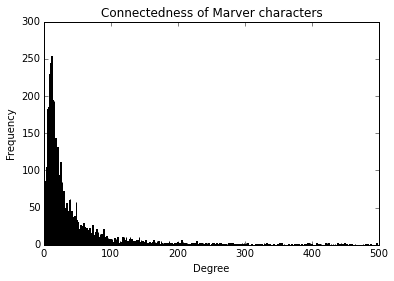

In [13]:

plt.hist(filter(lambda v: v < 500, graph.degree().values()), bins = 500)
plt.title("Connectedness of Marver characters")
plt.xlabel("Degree")
plt.ylabel("Frequency")
plt.show()

In [82]:
filter(lambda v: v < 500, graph.degree().values())

[39,
 10,
 44,
 42,
 18,
 126,
 37,
 97,
 11,
 47,
 25,
 12,
 5,
 242,
 153,
 76,
 145,
 44,
 43,
 148,
 61,
 110,
 36,
 13,
 5,
 407,
 18,
 19,
 8,
 11,
 6,
 11,
 77,
 12,
 11,
 25,
 30,
 11,
 51,
 25,
 13,
 14,
 17,
 8,
 16,
 17,
 48,
 5,
 17,
 161,
 19,
 60,
 7,
 1,
 210,
 4,
 4,
 34,
 29,
 7,
 393,
 28,
 20,
 7,
 42,
 34,
 9,
 16,
 5,
 28,
 10,
 12,
 19,
 11,
 14,
 23,
 56,
 26,
 13,
 49,
 25,
 8,
 8,
 28,
 4,
 20,
 72,
 15,
 18,
 18,
 104,
 7,
 233,
 11,
 37,
 78,
 115,
 26,
 14,
 73,
 25,
 34,
 7,
 84,
 11,
 3,
 77,
 58,
 12,
 26,
 120,
 8,
 77,
 14,
 78,
 59,
 32,
 20,
 11,
 3,
 86,
 15,
 15,
 20,
 56,
 175,
 14,
 13,
 21,
 25,
 275,
 12,
 3,
 181,
 89,
 15,
 87,
 23,
 176,
 72,
 23,
 31,
 34,
 34,
 29,
 8,
 33,
 44,
 10,
 16,
 9,
 38,
 30,
 44,
 23,
 18,
 23,
 26,
 64,
 8,
 11,
 12,
 8,
 11,
 8,
 123,
 29,
 16,
 15,
 83,
 18,
 12,
 43,
 12,
 31,
 66,
 43,
 8,
 299,
 13,
 18,
 20,
 4,
 35,
 24,
 101,
 110,
 8,
 12,
 20,
 77,
 17,
 10,
 4,
 5,
 8,
 24,
 55,
 59,
 37,
 23,
 123,
 

In [ ]:
bw_centrality = nx.betweenness_centrality(graph)
norm_centrality = nx.betweenness_centrality(graph, normalized = True)
weighted_centrality = nx.closeness_centrality(graph, distance='weight')
ev_centrality = nx.eigenvector_centrality(graph)

In [16]:
def nbest_centrality(graph, metric, n=10, attribute="centrality", **kwargs):
    centrality = metric(graph, **kwargs)
    nx.set_node_attributes(graph, attribute, centrality)
    degrees = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
    for idx, item in enumerate(degrees[0:n]):
        item = (idx+1,) + item
        print "%i. %s: %0.3f" % item

In [17]:
nbest_centrality(graph, nx.degree_centrality)

1. CAPTAIN AMERICA: 0.297
2. SPIDER-MAN/PETER PAR: 0.270
3. IRON MAN/TONY STARK : 0.237
4. THING/BENJAMIN J. GR: 0.220
5. MR. FANTASTIC/REED R: 0.215
6. WOLVERINE/LOGAN : 0.213
7. HUMAN TORCH/JOHNNY S: 0.212
8. SCARLET WITCH/WANDA : 0.206
9. THOR/DR. DONALD BLAK: 0.201
10. BEAST/HENRY &HANK& P: 0.197


In [22]:
ego = nx.ego_graph(graph, "LONGBOW/AMELIA GREER")
nx.density(ego)

0.7210144927536232

In [24]:
for subgraph in nx.connected_component_subgraphs(graph):
    print nx.diameter(subgraph)
    print nx.average_shortest_path_length(subgraph)

KeyboardInterrupt: 

In [25]:
G = nx.karate_club_graph()

In [26]:
G.size()

78

In [27]:
print nx.info(G)

Name: Zachary's Karate Club
Type: Graph
Number of nodes: 34
Number of edges: 78
Average degree:   4.5882


In [28]:
nx.is_connected(G)

True

In [30]:
nx.average_shortest_path_length(G)

2.408199643493761

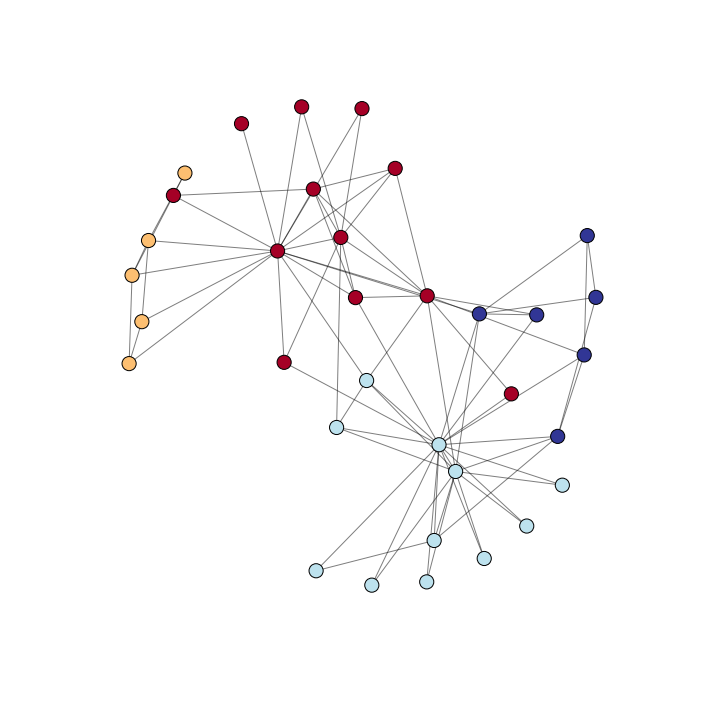

In [33]:
partition = community.best_partition(G)
pos = nx.spring_layout(G)
pos = nx.spring_layout(G)
plt.figure(figsize=(12,12))
plt.axis('off')

nx.draw_networkx_nodes(G, pos, node_size=200, cmap=plt.cm.RdYlBu, node_color=partition.values())
nx.draw_networkx_edges(G,pos, alpha=0.5)
plt.show()